In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.image as mping
import tensorflow as tf

<>:1: SyntaxWarning: invalid escape sequence '\h'
<>:1: SyntaxWarning: invalid escape sequence '\h'
C:\Users\derek\AppData\Local\Temp\ipykernel_21036\2110257195.py:1: SyntaxWarning: invalid escape sequence '\h'
  image = mping.imread('images\heat equation.png')


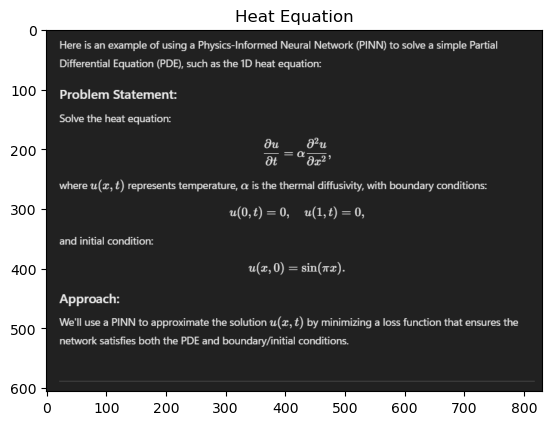

In [13]:
image = mping.imread('images\heat equation.png')

plt.imshow(image)
plt.title('Heat Equation')
plt.axis('on')
plt.show()


In [14]:
# Define constants
alpha = 0.01  # Thermal diffusivity
N_train = 10000  # Number of training points

x = np.random.uniform(0, 1, N_train)
t = np.random.uniform(0, 1, N_train)
X_train = np.stack([x, t], axis=1)

print(X_train)

[[0.53447188 0.42541133]
 [0.97928429 0.19481217]
 [0.15458847 0.80992436]
 ...
 [0.04176719 0.67312579]
 [0.20844044 0.5643853 ]
 [0.75809015 0.23807712]]


In [15]:
# Boundary conditions
X_bc = np.array([[0, t] for t in np.linspace(0, 1, 100)] + [[1, t] for t in np.linspace(0, 1, 100)])
u_bc = np.zeros((len(X_bc), 1))

# Initial condition
X_ic = np.array([[x, 0] for x in np.linspace(0, 1, 100)])
u_ic = np.sin(np.pi * X_ic[:, 0:1])

In [16]:
#print(X_bc.shape)
#print(u_bc)

In [17]:
# Build the PINN model
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layers = [tf.keras.layers.Dense(20, activation='tanh') for _ in range(4)]
        self.output_layer = tf.keras.layers.Dense(1, activation=None)
    
    def call(self, inputs):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

# Initialize model and optimizer
model = PINN()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

def compute_loss(model, X_train, X_bc, u_bc, X_ic, u_ic):
    # Convert inputs to TensorFlow tensors
    X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
    X_bc = tf.convert_to_tensor(X_bc, dtype=tf.float32)
    u_bc = tf.convert_to_tensor(u_bc, dtype=tf.float32)
    X_ic = tf.convert_to_tensor(X_ic, dtype=tf.float32)
    u_ic = tf.convert_to_tensor(u_ic, dtype=tf.float32)
    
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(X_train)
        u_pred = model(X_train)
        u_bc_pred = model(X_bc)
        u_ic_pred = model(X_ic)
        
        # Compute gradients for PDE loss
        u_x = tape.gradient(u_pred, X_train)[:, 0:1]
        u_t = tape.gradient(u_pred, X_train)[:, 1:2]
        u_xx = tape.gradient(u_x, X_train)[:, 0:1]
    
    # PDE loss
    pde_loss = tf.reduce_mean((u_t - alpha * u_xx)**2)
    
    # Boundary condition loss
    bc_loss = tf.reduce_mean((u_bc_pred - u_bc)**2)
    
    # Initial condition loss
    ic_loss = tf.reduce_mean((u_ic_pred - u_ic)**2)
    
    return pde_loss + bc_loss + ic_loss


# Training loop
for epoch in range(1000):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, X_train, X_bc, u_bc, X_ic, u_ic)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy()}")

# Testing
x_test = np.linspace(0, 1, 100)
t_test = np.linspace(0, 1, 100)
X_test = np.array([[xi, ti] for xi in x_test for ti in t_test])
u_pred = model(X_test).numpy()


Epoch 0, Loss: 0.7895358204841614
Epoch 100, Loss: 0.17100274562835693
Epoch 200, Loss: 0.012718080542981625
Epoch 300, Loss: 0.007421539165079594
Epoch 400, Loss: 0.004827452823519707
Epoch 500, Loss: 0.0033493787050247192
Epoch 600, Loss: 0.002415677532553673
Epoch 700, Loss: 0.0017773113213479519
Epoch 800, Loss: 0.0013185534626245499
Epoch 900, Loss: 0.000995673006400466


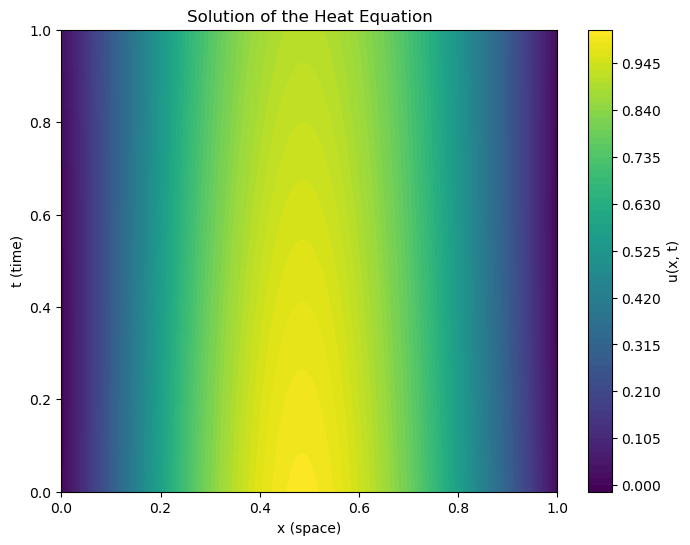

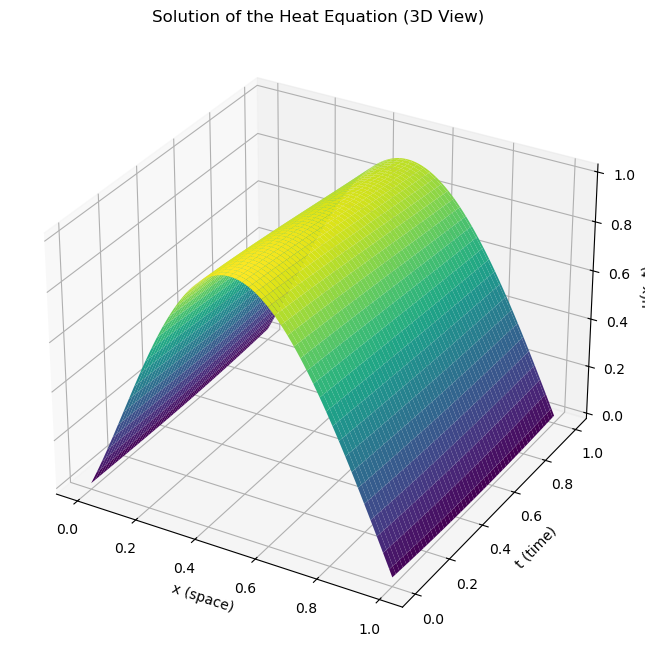

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate a grid of points in the (x, t) domain
x_vals = np.linspace(0, 1, 100)
t_vals = np.linspace(0, 1, 100)
X, T = np.meshgrid(x_vals, t_vals)
X_test = np.array([X.ravel(), T.ravel()]).T  # Flatten grid for model input

# Predict the solution using the trained model
u_pred = model(tf.convert_to_tensor(X_test, dtype=tf.float32)).numpy()
U_pred = u_pred.reshape(X.shape)  # Reshape to match the grid

# Plot 2D heatmap
plt.figure(figsize=(8, 6))
plt.contourf(X, T, U_pred, 100, cmap='viridis')
plt.colorbar(label='u(x, t)')
plt.xlabel('x (space)')
plt.ylabel('t (time)')
plt.title('Solution of the Heat Equation')
plt.show()

# Plot 3D surface
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, U_pred, cmap='viridis')
ax.set_xlabel('x (space)')
ax.set_ylabel('t (time)')
ax.set_zlabel('u(x, t)')
ax.set_title('Solution of the Heat Equation (3D View)')
plt.show()

